# Evaluation - IJGI_2018

For http://www.mdpi.com/journal/ijgi Journal

## Evaluations and results

In [1]:
import numpy as np
import sklearn.metrics as skmetrics
from os.path import join

#path="/media/data/marc/eval/fields/convgru128"
#path="/media/data/marc/eval/2018_IJGI/convlstm256_48px/eval"

datafolder="data_IJGI18"
model24px="convgru256"
model48px="convgru256_48px"

write_flag=False

#path="data/bavaria/models/fine_tuned/convgru256/eval"
quantevalpath=join(datafolder,"eval","full",model24px) # 'full' or 'demo'
qualevalpath=join(datafolder,"eval","demo",model48px)  # 'full' or 'demo'

docpath=join(datafolder,"doc")

dat = np.loadtxt(join(quantevalpath,"2016","classes.csv"),dtype=str, delimiter=',')
ids = [int(id) for id in dat[:,0]]
names = classes = dat[:,1]

colarray = [[0,101,189],[0, 0, 0],[79,76,76],[0,82,147],[152,198,234],[100,160,200],[218,215,203],[162,173,0],[227,114,34],[105,8,90],[15,27,95],[0,119,138],[0,124,48],[103,154,29],[255,220,0],[249,186,0],[214,76,19],[196,72,27],[156,13,22]]
tumcolors=np.array([np.array(col+[255],dtype=float)/255 for col in colarray*10])

## Satellite Availability

(-0.5, 1.2)

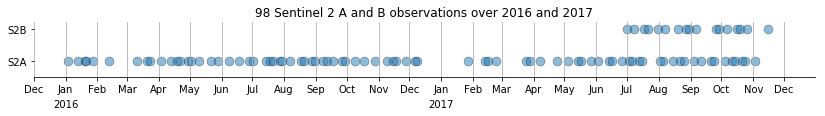

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
import os
%matplotlib inline

fn = join("data_IJGI18","observations.csv")
# from db (to file)
if False:
    import psycopg2
    with open(os.path.join(os.environ["HOME"],".pgpass"),'r') as f:
        pgpass = f.readline().replace("\n","")
    host, port, db, user, password = pgpass.split(':')
    conn = psycopg2.connect('postgres://{}:{}@{}/{}'.format(user,password,host,db))

    data = pd.read_sql("select distinct date, sat from bavaria order by date",conn)
    
    # add categorical id for easier plotting
    data["sat_id"] = data["sat"].astype('category').cat.codes
    data.to_csv(fn)
    # from file
else:
    data = pd.read_csv(fn,index_col=0)
    
dates=data["date"].sort_values()
sat=data["sat"].astype("category")
#color=scl.sort_index()["cloud"]

if type(dates.values[0])==str: #parse to datetime
    X = [datetime.strptime(d, '%Y-%m-%d') for d in dates.values]
else: # assume already datetime
    X = dates.values
Y = data["sat_id"]
fig, ax = plt.subplots(figsize=(14,1))
sc = ax.scatter(X, Y,
           marker='o', s=80, edgecolors="#000000", linewidth=.5, alpha=.5, cmap="Blues_r", vmin=0, vmax=1)

#cbar = plt.colorbar(sc,aspect=3, ticks=[0, .5, 1])
#cbar.ax.set_yticklabels(['0% clouds', '50% clouds', '100 % clouds']) 

xticks = [datetime(year,month,1) for month in range(1,12,2) for year in [2016,2017]]
ax.xaxis.set_ticks(xticks)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# everything after this is turning off stuff that's plotted by default

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
monthsFmt = mdates.DateFormatter('%b')
yearsFmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_minor_locator(years)
ax.xaxis.set_minor_formatter(yearsFmt)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_tick_params(which='minor', pad=20)

#ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.xaxis.set_ticks_position('bottom')

ax.xaxis.grid(True, which="major")
#ax.yaxis.grid()

plt.yticks(sat.cat.codes.unique(), sat.cat.categories)

plt.xlim(datetime(2015,12,1), datetime(2017,12,31))

ax.set_title("{} Sentinel 2 A and B observations over 2016 and 2017".format(len(dates)))

plt.ylim(-.5, 1.2)

## Per Class accuracies

In [3]:
data16 =np.load(join(quantevalpath,"2016","truepred.npy"))
data17 =np.load(join(quantevalpath,"2017","truepred.npy"))
data = np.vstack((data16,data17))

y_true = data[:,0]
y_pred = data[:,1]

print(skmetrics.classification_report(y_true, y_pred, labels=ids, target_names=names))

                   precision    recall  f1-score   support

       sugar beet       0.91      0.78      0.84    153010
       summer oat       0.73      0.65      0.69     73695
           meadow       0.89      0.85      0.87    475047
             rape       0.96      0.93      0.94    238215
              hop       0.95      0.81      0.87    103868
     winter spelt       0.60      0.65      0.63     68519
 winter triticale       0.66      0.56      0.61    128810
            beans       0.93      0.75      0.83     55432
             peas       0.81      0.59      0.68     15621
          potatoe       0.93      0.81      0.86    265914
         soybeans       0.84      0.80      0.82     46498
        asparagus       0.85      0.78      0.82     39633
     winter wheat       0.89      0.94      0.91   1589217
    winter barley       0.94      0.90      0.92    512710
       winter rye       0.81      0.53      0.64     72722
    summer barley       0.82      0.86      0.84    163

In [4]:
def calc_avg(y_true,y_pred,function):
    micro = function(y_true, y_pred, labels=ids,average='micro')
    macro = function(y_true, y_pred, labels=ids,average='macro')
    weighted = function(y_true, y_pred, labels=ids,average='weighted')
    return micro,macro,weighted

dec = 2
prec,rec,fscore,sup = skmetrics.precision_recall_fscore_support(y_true, y_pred, beta=1.0, labels=ids)

avg_prec = skmetrics.precision_score(y_true, y_pred, labels=ids,average='weighted')
avg_rec = skmetrics.recall_score(y_true, y_pred, labels=ids,average='weighted')
avg_fscore = skmetrics.f1_score(y_true, y_pred, labels=ids,average='weighted')

if write_flag:

    metrics = np.column_stack((classes,np.around(prec,dec),np.around(rec,dec),np.around(fscore,dec),sup))
    with open(join(quantevalpath,"metrics.csv"), 'w') as f:
        f.write(b'id,name,precision,recall,fscore,support\n')
        np.savetxt(f, metrics, fmt='%s', delimiter=', ', newline='\n')
        f.write(b',,,,,\n'.format(prec=avg_prec, rec=avg_rec, fsc=avg_fscore))
        f.write(b',weight. avg,{prec},{rec},{fsc},\n'.format(prec=np.around(avg_prec,dec),rec=np.around(avg_rec,dec),fsc=np.around(avg_fscore,dec)))

## Confusion Matrix

In [5]:
cm = skmetrics.confusion_matrix(y_true, y_pred)

#sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, beta=1.0, labels=None)

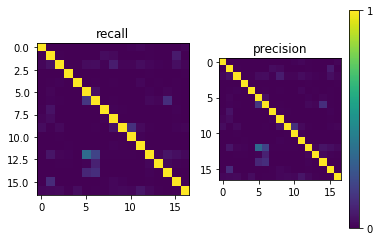

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,axs = plt.subplots(1,2)
axs[0].imshow(cm/cm.max(axis=1).astype(float))
axs[0].set_title("recall")

cax = axs[1].imshow(cm/cm.max(axis=0).astype(float))
axs[1].set_title("precision")
cbar = fig.colorbar(cax, ticks=[0, 1], orientation='vertical')

In [7]:
classnames = classes

import csv

def write_flat_cm(confusion_matrix, outfile):
    precision = confusion_matrix/(confusion_matrix.sum(axis=0)+1e-10)
    recall = confusion_matrix/(confusion_matrix.sum(axis=1)+1e-10)

    outcsv = ""
    rows,columns = confusion_matrix.shape
    for c in range(columns):
        for r in range(rows):
            row="{r} {c} {absolute} {precision} {recall}".format(r=r+1,c=c+1,absolute=int(confusion_matrix[r,c]), precision=precision[r,c], recall=recall[r,c])
            outcsv+=row+"\n"

    with open(outfile,"w") as f:
        f.write(outcsv)



In [8]:
if write_flag:

    # Absolut
    with open(join(quantevalpath,'confusion_matrix_abs.csv'), 'wb') as f:
        f.write(", ".join(classnames)+"\n")
        np.savetxt(f, cm, fmt='%d', delimiter=', ', newline='\n')

    # Precision
    with open(join(quantevalpath,'confusion_matrix_prec.csv'), 'wb') as f:
        f.write(", ".join(classnames)+"\n")
        np.savetxt(f, cm/cm.sum(axis=0).astype(float), fmt='%f', delimiter=', ', newline='\n')

    # Recall
    with open(join(quantevalpath,'confusion_matrix_rec.csv'), 'wb') as f:
        f.write(", ".join(classnames)+"\n")
        np.savetxt(f, cm/cm.sum(axis=1).astype(float), fmt='%f', delimiter=', ', newline='\n')

    # write these out as flat confusion matrix for tikz pgf plotting...
    write_flat_cm(confusion_matrix=cm, outfile=join(quantevalpath,'confusion_matrix_tikz.csv'))

## Write flat confusion matrix for paper

In [9]:
import numpy as np
import csv

filename= 'confusion_matrix.csv'

def write_flat_cm(confusion_matrix, outfile):

    with open(filename,'r') as f:
        header = f.readline()

    precision = confusion_matrix/(confusion_matrix.sum(axis=0)+1e-10)
    recall = confusion_matrix/(confusion_matrix.sum(axis=1)+1e-10)

    outcsv = ""
    rows,columns = confmat.shape
    for c in range(columns):
        for r in range(rows):
            row="{r} {c} {absolute} {precision} {recall}".format(r=r+1,c=c+1,absolute=int(confmat[r,c]), precision=precision[r,c], recall=recall[r,c])
            outcsv+=row+"\n"

    with open(outfile,"w") as f:
        f.write(outcsv)

## Visualize the Class activations of some tiles

In [10]:
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual

from PIL import Image
from os.path import join
import os

#model="data/bavaria/models/fine_tuned/convlstm256_48px/eval/2017"
tiles = [int(t.split(".")[0]) for t in os.listdir(join(qualevalpath,"2017","ground_truth"))]

In [11]:
def plot_class(ax, tileid, folder="ground_truth", title="ground truth",cmap="Accent"):
    #im = plt.imread(join(model,folder,str(tileid)+".tif"))[:,:,0]
    im = Image.open(join(qualevalpath,"2017",folder,str(tileid)+".tif"))
    arr=np.asarray(im)
    ax.set_axis_off()
    #arr[arr==0]=np.nan
    #plt.set_clim(vmin=0, vmax=27)
    #cmap=plt.get_cmap("gist_earth")
    #print cmap.get_clim()
    if cmap=='tum': 
        colors = tumcolors
        rs = np.zeros(arr.shape,dtype=int)
        lut = [0]+ids
        for i in ids:
            np.place(rs, arr==i, lut.index(i))
        arr=rs
    else: colors = plt.get_cmap(cmap)(np.linspace(0,1,27))
    colors[0]=np.array([1,1,1,1])
    colored_im = colors[arr]
    ax.imshow(colored_im)
    ax.set_title(title)
    #ax.colorbar()
    
def plot_activation(ax, tileid, folder="loss", title="loss",vmax=None):
    
    #ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    #im = plt.imread(join(model,folder,str(tileid)+".tif"))[:,:,0]
    im = Image.open(join(qualevalpath,"2017",folder,str(tileid)+".tif"))
    #np.asarray(im)
    cmap = plt.get_cmap("inferno")
    image=cmap(np.asarray(im))
    ax.imshow(image, cmap="inferno",vmin=0, vmax=vmax)
    ax.set_title(title)

def plot_tile(tileidx):
    tileid=tiles[tileidx]
    
    fig, axs = plt.subplots(5,4, figsize=(10,12))
    
    
    plt.suptitle('Tile '+(str(tileid)))
    
    #axs = [ax for ax in ax_row for ax_row in axs]
    axs_list=list()
    for ax_row in axs:
        for ax in ax_row:
            axs_list.append(ax)

    plot_class(axs_list.pop(0),tileid, folder="ground_truth", title="ground truth",cmap="tum")
    plot_class(axs_list.pop(0),tileid, folder="prediction", title="prediction",cmap="tum")
    plot_activation(axs_list.pop(0),tileid, folder="loss", title="loss",vmax=1)

    flds = ["1_sugar_beet","2_summer_oat","3_meadow","4_rape","5_hop","6_winter_spelt","7_winter_triticale","8_beans","9_peas",
    "10_potatoe","11_soybeans","12_asparagus","13_winter_wheat","14_winter_barley","15_winter_rye","16_summer_barley","17_maize"]

    names=[" ".join(el.split("_")[1:]) for el in flds]

    #plot_activation(axs_list[0],tileid, folder="confidences/"+flds[0], title=names[0])
    #plot_activation(axs_list[1],tileid, folder="confidences/"+flds[1], title=names[1])
    #plot_activation(axs_list[2],tileid, folder="confidences/"+flds[2], title=names[2])
    for fld,name in zip(flds,names):
        plot_activation(axs_list.pop(0),tileid, folder="confidences/"+fld, title=name,vmax=1)

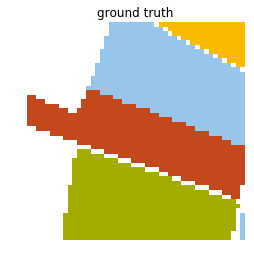

In [12]:
fig,ax=plt.subplots()
plot_class(ax, 10969, folder="ground_truth", title="ground truth",cmap="tum")

In [13]:
tile_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(tiles)-1,
    step=1,
    description='Tile:'
)
interact(plot_tile,tileidx=tile_slider)

A Jupyter Widget

<function __main__.plot_tile>